In [2]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import pandas as pd
import numpy as np
#import seaborn as sns
pd.set_option('display.max_columns', 500)
from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

from torch.nn import init
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

##  helpers

In [3]:
def haversine_distance(df, start_lat, end_lat, start_lng, end_lng, prefix):
    """
    calculates haversine distance between 2 sets of GPS coordinates in df
    """
    R = 6371  #radius of earth in kilometers
       
    phi1 = np.radians(df[start_lat])
    phi2 = np.radians(df[end_lat])
    
    delta_phi = np.radians(df[end_lat]-df[start_lat])
    delta_lambda = np.radians(df[end_lng]-df[start_lng])
    
        
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (R * c) #in kilometers
    df[prefix+'distance_km'] = d

def add_datepart(df, col, prefix):
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(df[col].dt, n.lower())
    df[prefix + 'Elapsed'] = df[col].astype(np.int64) // 10 ** 9
    df.drop(col, axis=1, inplace=True)
    
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/(mdev if mdev else 1.)
    return s<m

def parse_gps(df, prefix):
    lat = prefix + '_latitude'
    lon = prefix + '_longitude'
    df[prefix + '_x'] = np.cos(df[lat]) * np.cos(df[lon])
    df[prefix + '_y'] = np.cos(df[lat]) * np.sin(df[lon]) 
    df[prefix + '_z'] = np.sin(df[lat])
    df.drop([lat, lon], axis=1, inplace=True)
    
def prepare_dataset(df):
    df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime, infer_datetime_format=True)
    add_datepart(df, 'pickup_datetime', 'pickup')
    haversine_distance(df, 'pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude', '')
    parse_gps(df, 'pickup')
    parse_gps(df, 'dropoff')
    df.dropna(inplace=True)
    y = np.log(df.fare_amount)
    df.drop(['key', 'fare_amount'], axis=1, inplace=True)
    
    return df, y

def split_features(df):
    catf = ['pickupYear', 'pickupMonth', 'pickupWeek', 'pickupDay', 'pickupDayofweek', 
            'pickupDayofyear', 'pickupHour', 'pickupMinute', 'pickupSecond', 'pickupIs_month_end',
            'pickupIs_month_start', 'pickupIs_quarter_end', 'pickupIs_quarter_start',
            'pickupIs_year_end', 'pickupIs_year_start']

    numf = [col for col in df.columns if col not in catf]
    for c in catf: 
        df[c] = df[c].astype('category').cat.as_ordered()
        df[c] = df[c].cat.codes+1
    
    return catf, numf

def numericalize(df):
    df[name] = col.cat.codes+1

def split_dataset(df, y): return train_test_split(df, y, test_size=0.25, random_state=42)

def inv_y(y): return np.exp(y)

def get_numf_scaler(train): return preprocessing.StandardScaler().fit(train)

def scale_numf(df, num, scaler):
    cols = numf
    index = df.index
    scaled = scaler.transform(df[numf])
    scaled = pd.DataFrame(scaled, columns=cols, index=index)
    return pd.concat([scaled, df.drop(numf, axis=1)], axis=1)

class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        self.dfcats = df[cats]
        self.dfconts = df.drop(cats, axis=1)
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64)
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        self.y = y.values.astype(np.float32)
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    
def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()

def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn=True):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, f"cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x.squeeze()

def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad()
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            loss.backward()
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            scheduler.step()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

## data prep

In [20]:
PATH='../data/taxi/'

In [21]:
!ls {PATH}

 GCP-Coupons-Instructions.rtf   test.csv
 sample_submission.csv	       'Unconfirmed 330019.crdownload'


In [116]:
names = ['key','fare_amount','pickup_datetime','pickup_longitude',
         'pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']

In [117]:
df = pd.read_csv(f'{PATH}train.csv', header=1, names=names, nrows=500000, low_memory=False, sep=',')

## EDA

In [109]:
df.shape
df.head()

(500000, 8)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
1,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
2,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
3,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
4,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1


In [110]:
df.passenger_count.describe()
df.passenger_count.quantile([.85, .99])

count    500000.000000
mean          1.683430
std           1.307395
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

0.85    3.0
0.99    6.0
Name: passenger_count, dtype: float64

In [111]:
df.fare_amount.describe()
df.fare_amount.quantile([.85, .99])

count    500000.000000
mean         11.358404
std           9.916634
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

0.85    16.500
0.99    52.101
Name: fare_amount, dtype: float64

In [118]:
df = df.loc[(df.fare_amount > 0) & (df.passenger_count < 6) & (df.fare_amount < 53),:]

In [119]:
df, y = prepare_dataset(df)

df.shape
df.head()

(484628, 24)

,passenger_count,pickupYear,pickupMonth,pickupWeek,pickupDay,pickupDayofweek,pickupDayofyear,pickupIs_month_end,pickupIs_month_start,pickupIs_quarter_end,pickupIs_quarter_start,pickupIs_year_end,pickupIs_year_start,pickupHour,pickupMinute,pickupSecond,pickupElapsed,distance_km,pickup_x,pickup_y,pickup_z,dropoff_x,dropoff_y,dropoff_z
0,1,2010,1,1,5,1,5,False,False,False,False,False,False,16,52,16,1262710336,8.450134,-0.185937,-0.974051,0.129041,-0.150997,-0.986792,0.058667
1,2,2011,8,33,18,3,230,False,False,False,False,False,False,0,35,0,1313627700,1.389525,-0.154199,-0.984848,0.079351,-0.162421,-0.982607,0.090020
2,1,2012,4,16,21,5,112,False,False,False,False,False,False,4,30,42,1334982642,2.799270,-0.158106,-0.981569,0.107354,-0.162846,-0.983195,0.082519
3,1,2010,3,10,9,1,68,False,False,False,False,False,False,7,51,0,1268121060,1.999157,-0.139834,-0.987507,0.072632,-0.128659,-0.990054,0.056912
4,1,2011,1,1,6,3,6,False,False,False,False,False,False,9,50,45,1294307445,3.787239,-0.171641,-0.979127,0.108858,-0.144460,-0.986076,0.082378


In [120]:
catf, numf = split_features(df)

len(catf)
catf

len(numf)
numf

15

['pickupYear',
 'pickupMonth',
 'pickupWeek',
 'pickupDay',
 'pickupDayofweek',
 'pickupDayofyear',
 'pickupHour',
 'pickupMinute',
 'pickupSecond',
 'pickupIs_month_end',
 'pickupIs_month_start',
 'pickupIs_quarter_end',
 'pickupIs_quarter_start',
 'pickupIs_year_end',
 'pickupIs_year_start']

9

['passenger_count',
 'pickupElapsed',
 'distance_km',
 'pickup_x',
 'pickup_y',
 'pickup_z',
 'dropoff_x',
 'dropoff_y',
 'dropoff_z']

In [121]:
df.head()

,passenger_count,pickupYear,pickupMonth,pickupWeek,pickupDay,pickupDayofweek,pickupDayofyear,pickupIs_month_end,pickupIs_month_start,pickupIs_quarter_end,pickupIs_quarter_start,pickupIs_year_end,pickupIs_year_start,pickupHour,pickupMinute,pickupSecond,pickupElapsed,distance_km,pickup_x,pickup_y,pickup_z,dropoff_x,dropoff_y,dropoff_z
0,1,2,1,1,5,2,5,1,1,1,1,1,1,17,53,17,1262710336,8.450134,-0.185937,-0.974051,0.129041,-0.150997,-0.986792,0.058667
1,2,3,8,33,18,4,230,1,1,1,1,1,1,1,36,1,1313627700,1.389525,-0.154199,-0.984848,0.079351,-0.162421,-0.982607,0.090020
2,1,4,4,16,21,6,112,1,1,1,1,1,1,5,31,43,1334982642,2.799270,-0.158106,-0.981569,0.107354,-0.162846,-0.983195,0.082519
3,1,2,3,10,9,2,68,1,1,1,1,1,1,8,52,1,1268121060,1.999157,-0.139834,-0.987507,0.072632,-0.128659,-0.990054,0.056912
4,1,3,1,1,6,4,6,1,1,1,1,1,1,10,51,46,1294307445,3.787239,-0.171641,-0.979127,0.108858,-0.144460,-0.986076,0.082378


In [122]:
X_train, X_test, y_train, y_test = split_dataset(df, y)

X_train.shape
X_test.shape

(363471, 24)

(121157, 24)

In [123]:
scaler = get_numf_scaler(X_train[numf])

X_train_sc = scale_numf(X_train, numf, scaler)
X_train_sc.std(axis=0)

/home/michael/anaconda3/envs/p36-fastai10-cuda100/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/michael/anaconda3/envs/p36-fastai10-cuda100/lib/python3.6/site-packages/ipykernel_launcher.py:78: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


passenger_count             1.000001
pickupElapsed               1.000001
distance_km                 1.000001
pickup_x                    1.000001
pickup_y                    1.000001
pickup_z                    1.000001
dropoff_x                   1.000001
dropoff_y                   1.000001
dropoff_z                   1.000001
pickupYear                  1.859568
pickupMonth                 3.436839
pickupWeek                 14.950135
pickupDay                   8.682772
pickupDayofweek             1.949184
pickupDayofyear           104.808350
pickupIs_month_end          0.178913
pickupIs_month_start        0.173276
pickupIs_quarter_end        0.104055
pickupIs_quarter_start      0.096670
pickupIs_year_end           0.049284
pickupIs_year_start         0.045619
pickupHour                  6.514621
pickupMinute               17.334840
pickupSecond               19.492047
dtype: float64

In [124]:
X_test_sc = scale_numf(X_test, numf, scaler)

X_train_sc.shape
X_test_sc.shape
X_test_sc.std(axis=0)

/home/michael/anaconda3/envs/p36-fastai10-cuda100/lib/python3.6/site-packages/ipykernel_launcher.py:78: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


(363471, 24)

(121157, 24)

passenger_count             1.002221
pickupElapsed               0.998891
distance_km                 1.015501
pickup_x                    0.994553
pickup_y                    0.997088
pickup_z                    1.015483
dropoff_x                   0.992178
dropoff_y                   0.992328
dropoff_z                   1.019064
pickupYear                  1.857938
pickupMonth                 3.437416
pickupWeek                 14.954586
pickupDay                   8.678158
pickupDayofweek             1.947509
pickupDayofyear           104.825089
pickupIs_month_end          0.178136
pickupIs_month_start        0.174921
pickupIs_quarter_end        0.103185
pickupIs_quarter_start      0.098166
pickupIs_year_end           0.047329
pickupIs_year_start         0.046452
pickupHour                  6.531577
pickupMinute               17.324368
pickupSecond               19.517902
dtype: float64

## datasets, dataloader

In [125]:
trainds = RegressionColumnarDataset(X_train_sc, catf, y_train)
valds = RegressionColumnarDataset(X_test_sc, catf, y_test)

In [126]:
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 8}

traindl = data.DataLoader(trainds, **params)
valdl = data.DataLoader(valds, **params)

## Defining model and related variables

In [127]:
y_range = (0, y_train.max()*1.2)
y_range

cat_sz = [(c, df[c].max()+1) for c in catf]
cat_sz

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

(0, 4.764123859805604)

[('pickupYear', 8),
 ('pickupMonth', 13),
 ('pickupWeek', 54),
 ('pickupDay', 32),
 ('pickupDayofweek', 8),
 ('pickupDayofyear', 367),
 ('pickupHour', 25),
 ('pickupMinute', 61),
 ('pickupSecond', 61),
 ('pickupIs_month_end', 3),
 ('pickupIs_month_start', 3),
 ('pickupIs_quarter_end', 3),
 ('pickupIs_quarter_start', 3),
 ('pickupIs_year_end', 3),
 ('pickupIs_year_start', 3)]

[(8, 4),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (25, 13),
 (61, 31),
 (61, 31),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [128]:
m = MixedInputModel(emb_szs=emb_szs, 
                    n_cont=len(df.columns)-len(catf), 
                    emb_drop=0.04, 
                    out_sz=1, 
                    szs=[1000,500,250], 
                    drops=[0.001,0.01,0.01], 
                    y_range=y_range).to(device)

opt = optim.Adam(m.parameters(), 1e-2)
lr_cosine = lr_scheduler.CosineAnnealingLR(opt, 1000)

lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [129]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(13, 7)
    (2): Embedding(54, 27)
    (3): Embedding(32, 16)
    (4): Embedding(8, 4)
    (5): Embedding(367, 50)
    (6): Embedding(25, 13)
    (7): Embedding(61, 31)
    (8): Embedding(61, 31)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
    (14): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=204, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=250, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=250, out_features=1, bia

## training

In [130]:
lr, tloss, vloss = fit(model=m, train_dl=traindl, val_dl=valdl,
                       loss_fn=F.mse_loss, opt=opt, scheduler=lr_cosine, epochs=10)

Epoch 0: train_loss: 0.1068 train_rmse: 4.5773 | val_loss: 0.0778 val_rmse: 3.8534


Epoch 1: train_loss: 0.0810 train_rmse: 3.9206 | val_loss: 0.0807 val_rmse: 3.9467


Epoch 2: train_loss: 0.0812 train_rmse: 3.9386 | val_loss: 0.0774 val_rmse: 3.8474


Epoch 3: train_loss: 0.0766 train_rmse: 3.8329 | val_loss: 0.0733 val_rmse: 3.7207


Epoch 4: train_loss: 0.0778 train_rmse: 3.8739 | val_loss: 0.0767 val_rmse: 3.8083


Epoch 5: train_loss: 0.0749 train_rmse: 3.7810 | val_loss: 0.0718 val_rmse: 3.7223


Epoch 6: train_loss: 0.0751 train_rmse: 3.7939 | val_loss: 0.0803 val_rmse: 4.0509


Epoch 7: train_loss: 0.0747 train_rmse: 3.7911 | val_loss: 0.0717 val_rmse: 3.6909


Epoch 8: train_loss: 0.0732 train_rmse: 3.7362 | val_loss: 0.0732 val_rmse: 3.7040


Epoch 9: train_loss: 0.0737 train_rmse: 3.7559 | val_loss: 0.0716 val_rmse: 3.6962



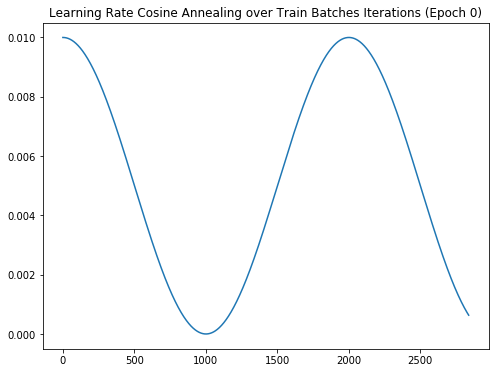

In [131]:
_ = plt.plot(lr[0])
_ = plt.title('Learning Rate Cosine Annealing over Train Batches Iterations (Epoch 0)')

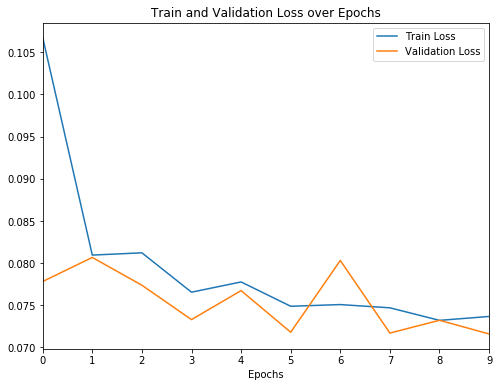

In [132]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]
p = pd.DataFrame({'Train Loss': t, 'Validation Loss': v, 'Epochs': range(10)})

_ = p.plot(x='Epochs', y=['Train Loss', 'Validation Loss'], 
           title='Train and Validation Loss over Epochs')

In [133]:
m(valdl)

TypeError: forward() missing 1 required positional argument: 'x_cont'